<a href="https://colab.research.google.com/github/Tbarkin121/ML_Examples/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to enable the GPU environment or this will take forever!

In [ ]:
import tensorflow as tf
import keras as K
import matplotlib.pyplot as plt

In [ ]:
class TransferLearningExample:
  def __init__(self):
    print('Init Transfer Learning Example')
    self.to_res = (224, 224)

  def preprocess_data(self, X, Y):
    """
    :param X: X is a numpy.ndarray of shape (m, 32, 32, 3) containing the
    data, where m is the number of data points
    :param Y: Y is a numpy.ndarray of shape (m,) containing the lables for X
    :return: X_p, Y_p
      X_p is a numpy.ndarray containing the preprocessed X
      Y_p is a numpy.ndarray containing the preprocessed Y 
    """
    X_p = K.applications.resnet50.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

  def get_data(self):
    (x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
    self.x_train, self.y_train = self.preprocess_data(x_train, y_train)
    self.x_test, self.y_test = self.preprocess_data(x_test, y_test)
    print('x_train shape, y_train shape')
    print((self.x_train.shape, self.y_train.shape))

  def create_model(self):
    # input_t = K.Input(shape=(32, 32, 3))
    # res_model = K.applications.ResNet50(include_top=False,
    #                                     weights="imagenet",
    #                                     input_tensor=input_t)
    res_model = K.applications.ResNet50(include_top=False,
                                        weights="imagenet")

    print('Num Layers in model = {}'.format(len(res_model.layers)))
    #It seems arbetray what layers we freeze and don't freeze so far...
    for layer in res_model.layers[:143]:
      layer.trainable = False

    temp = self.to_res
    self.model = K.models.Sequential()
    self.model.add(K.layers.Lambda(lambda image: tf.image.resize(image, temp)))
    self.model.add(res_model)
    self.model.add(K.layers.Flatten())
    self.model.add(K.layers.BatchNormalization())
    self.model.add(K.layers.Dense(256, activation='relu'))
    self.model.add(K.layers.Dropout(0.5))
    self.model.add(K.layers.BatchNormalization())
    self.model.add(K.layers.Dense(128, activation='relu'))
    self.model.add(K.layers.Dropout(0.5))
    self.model.add(K.layers.BatchNormalization())
    self.model.add(K.layers.Dense(64, activation='relu'))
    self.model.add(K.layers.Dropout(0.5))
    self.model.add(K.layers.BatchNormalization())
    self.model.add(K.layers.Dense(10, activation='softmax'))

  def run_training(self, num_epochs):
    check_point = K.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )
    self.model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])
    
    tmp_x_train=self.x_train
    tmp_y_train=self.y_train
    tmp_x_test=self.x_test
    tmp_y_test=self.y_test
    self.history = self.model.fit(tmp_x_train,
                        tmp_y_train,
                        batch_size=32,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=(tmp_x_test, tmp_y_test),
                        callbacks=[check_point])
    self.model.summary()
    self.model.save("cifar10.h5")

  def plot_results(self):
    acc = self.history.history['accuracy']
    val_acc = self.history.history['val_accuracy']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'bo', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
ex = TransferLearningExample()
ex.get_data()
ex.create_model()

# for i, layer in enumerate(ex.model.layers):
#       print(i, layer.name, "-",layer.trainable)

ex.run_training(1)


Init Transfer Learning Example
x_train shape, y_train shape
((50000, 32, 32, 3), (50000, 10))
Num Layers in model = 175
1563/1563 [==============================] - 262s 162ms/step - loss: 2.1940 - accuracy: 0.2814 - val_loss: 0.7049 - val_accuracy: 0.8626
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368

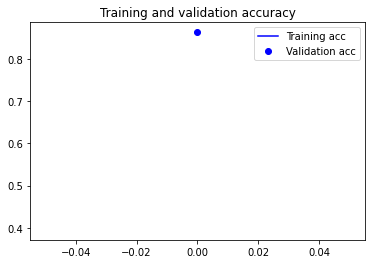

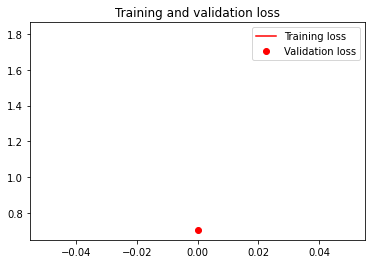

In [ ]:
ex.plot_results()